# Niqo Robotics Assignment
## Font Classification

### Author: Yashwanth A Doddegowda

This is the first part of the two part assignment, this part focuses on building a font classification model that would localize the text and classify the font in the text.

Training isn't provided. So I will also be generating the data required to train the model.

Usage of pre-trained modles are restricted. So, I will be using a customm model for this application.

In [ ]:
#installing necessary libraries

!pip install pillow opencv-python numpy

# 01. Data Generation

In this section of the code, I will be generating the images required to train the model. As given in the assignment I should focusing on many aspects to ensure that the training data is proper.

- I would need data of images with single font and images with multiple text with different fonts all with varying sizes.
- I would also need to annotate such data as I will be required to draw bounding boxes aroound the text
- The followiing section details on all these aspects

In [ ]:
# prompt: mount google drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
#importing the necessary libraries

from PIL import Image, ImageDraw, ImageFont
import requests
import os
import zipfile

- It turns out that automating the install of the fonts from google fonts is not possible as google doesn't have a formatted download url for each font
- The only two ways we can dowload now is either manually installing it and placing it in the directories or downloading the Google Fonts API to get the CSS of the fonts and use the links mentioned in the css.
- I am using hte second method, so that the code can be run in a new system as long as they oepn the collab notebook

In [ ]:
import re

# List of font names
fonts = [
    "Oswald", "Roboto", "Open+Sans", "Ubuntu", "PT+Serif",
    "Dancing+Script", "Fredoka+One", "Arimo", "Noto+Sans", "Patua+One"
]


def download_font(font_name):
    print(f"Downloading {font_name}...")
    css_url = f"https://fonts.googleapis.com/css?family={font_name}"
    css_response = requests.get(css_url)

    if css_response.status_code != 200:
        print(f"Failed to get CSS for {font_name}. Status code: {css_response.status_code}")
        return

    font_urls = re.findall(r'url\((https:\/\/.*?\.ttf)\)', css_response.text)

    if not font_urls:
        print(f"No font URLs found for {font_name}")
        return

    os.makedirs(font_name, exist_ok=True)

    for i, url in enumerate(font_urls):
        font_response = requests.get(url)
        if font_response.status_code == 200:
            filename = f"{font_name}_{i+1}.ttf"
            with open(os.path.join(font_name, filename), 'wb') as f:
                f.write(font_response.content)
            print(f"Downloaded {filename}")
        else:
            print(f"Failed to download a font file for {font_name}. Status code: {font_response.status_code}")

    print(f"Finished downloading {font_name}")

for font in fonts:
    download_font(font)

print("All fonts have been downloaded.")

Downloaded Oswald_1.ttf
Finished downloading Oswald
Downloaded Roboto_1.ttf
Finished downloading Roboto
Downloaded Open+Sans_1.ttf
Finished downloading Open+Sans
Downloaded Ubuntu_1.ttf
Finished downloading Ubuntu
Downloaded PT+Serif_1.ttf
Finished downloading PT+Serif
Downloaded Dancing+Script_1.ttf
Finished downloading Dancing+Script
Downloaded Fredoka+One_1.ttf
Finished downloading Fredoka+One
Downloaded Arimo_1.ttf
Finished downloading Arimo
Downloaded Noto+Sans_1.ttf
Finished downloading Noto+Sans
Downloaded Patua+One_1.ttf
Finished downloading Patua+One
All fonts have been downloaded.


In [ ]:
# creating the list of font paths

main_dir = '/content'

font_paths = []
for root, dirs, files in os.walk(main_dir):
    for file in files:
        if file.endswith('.ttf'):
            font_paths.append(os.path.join(root, file))

print(f'Found {len(font_paths)} fonts.')

print(font_paths)


Found 10 fonts.
['/content/Dancing+Script/Dancing+Script_1.ttf', '/content/Oswald/Oswald_1.ttf', '/content/Open+Sans/Open+Sans_1.ttf', '/content/Ubuntu/Ubuntu_1.ttf', '/content/Roboto/Roboto_1.ttf', '/content/Arimo/Arimo_1.ttf', '/content/Fredoka+One/Fredoka+One_1.ttf', '/content/Patua+One/Patua+One_1.ttf', '/content/Noto+Sans/Noto+Sans_1.ttf', '/content/PT+Serif/PT+Serif_1.ttf']


- The following section does the data generation of different fonts, with randomized font sizes

In [ ]:
import cv2
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import os
import random

def generate_dataset(num_images, output_dir, font_paths):
    os.makedirs(output_dir, exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'images'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'labels'), exist_ok=True)

    phrase = "Hello, World!"
    image_paths = []
    font_names = []

    for i in range(num_images):
        image_size = (320, 320)
        image = Image.new('RGB', image_size, color='white')
        draw = ImageDraw.Draw(image)

        font_path = random.choice(font_paths)
        font_size = random.randint(20, 40)
        font = ImageFont.truetype(font_path, font_size)

        text_width, text_height = draw.textsize(phrase, font=font)
        x = random.randint(0, image_size[0] - text_width)
        y = random.randint(0, image_size[1] - text_height)

        draw.text((x, y), phrase, font=font, fill='black')

        label = [x/image_size[0], y/image_size[1],
                 (x + text_width)/image_size[0], (y + text_height)/image_size[1]]

        image_path = os.path.join(output_dir, 'images', f'image_{i}.jpg')
        label_path = os.path.join(output_dir, 'labels', f'image_{i}.txt')

        image.save(image_path)
        np.savetxt(label_path, label, fmt='%.6f')

        image_paths.append(image_path)
        font_names.append(os.path.basename(font_path))

    print(f"Generated {num_images} images and labels.")
    return image_paths, font_names

image_paths, font_names = generate_dataset(5000, 'hello_world_dataset', font_paths)

for img_path, font_name in zip(image_paths[:10], font_names[:10]):
    print(f"Image: {img_path}, Font: {font_name}")


# 02. Training the Font Detection Model

As mentioned in the presentation we will be using the EAST model for font localization and TCR encode and fully connected neural network for the decoding and classification in the last stage

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import VisionEncoderDecoderModel, ViTFeatureExtractor
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image

class FontDataset(Dataset):
    def __init__(self, image_paths, font_labels, feature_extractor):
        self.image_paths = image_paths
        self.font_labels = font_labels
        self.feature_extractor = feature_extractor

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        inputs = self.feature_extractor(images=image, return_tensors="pt")
        inputs['pixel_values'] = inputs['pixel_values'].squeeze(0)
        label = self.font_labels[idx]
        return inputs['pixel_values'], label

class VisionEncoderFontClassifier(nn.Module):
    def __init__(self, num_fonts):
        super(VisionEncoderFontClassifier, self).__init__()
        self.encoder_decoder = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-handwritten")
        self.encoder = self.encoder_decoder.encoder
        self.fc = nn.Linear(self.encoder.config.hidden_size, num_fonts)

    def forward(self, pixel_values):
        encoder_outputs = self.encoder(pixel_values=pixel_values).last_hidden_state
        pooled_output = encoder_outputs[:, 0, :]
        font_logits = self.fc(pooled_output)

        return font_logits

feature_extractor = ViTFeatureExtractor.from_pretrained("microsoft/trocr-base-handwritten")


#testing the model

num_fonts = 10
model = VisionEncoderFontClassifier(num_fonts)
pixel_values = torch.randn(1, 3, 320, 320)

resize = transforms.Resize((384, 384))
pixel_values = resize(pixel_values)
font_logits = model(pixel_values)
font_class = font_logits.argmax().item()
print(f"Predicted font class: {font_class}")


#training the model


model.train()

# Optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()


train_dataset = FontDataset(image_paths,
                            font_names,
                            feature_extractor=feature_extractor)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

num_epochs = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    for pixel_values, labels in train_loader:
        pixel_values = pixel_values.to(device)
        labels = labels.to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(pixel_values)

        # Compute the loss
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate loss and accuracy
        total_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct_predictions += (preds == labels).sum().item()
        total_samples += labels.size(0)

    # Print epoch stats
    avg_loss = total_loss / len(train_loader)
    accuracy = correct_predictions / total_samples
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

print("Training Complete!")


In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

def decode_predictions(scores, geometry, min_confidence):
    (num_rows, num_cols) = scores.shape[2:4]
    rects = []
    confidences = []

    for y in range(num_rows):
        scores_data = scores[0, 0, y]
        x_data_0 = geometry[0, 0, y]
        x_data_1 = geometry[0, 1, y]
        x_data_2 = geometry[0, 2, y]
        x_data_3 = geometry[0, 3, y]
        angles_data = geometry[0, 4, y]

        for x in range(num_cols):
            if scores_data[x] < min_confidence:
                continue
            (offset_x, offset_y) = (x * 4.0, y * 4.0)

            angle = angles_data[x]
            cos = np.cos(angle)
            sin = np.sin(angle)

            h = x_data_0[x] + x_data_2[x]
            w = x_data_1[x] + x_data_3[x]


            end_x = int(offset_x + (cos * x_data_1[x]) + (sin * x_data_2[x]))
            end_y = int(offset_y - (sin * x_data_1[x]) + (cos * x_data_2[x]))
            start_x = int(end_x - w)
            start_y = int(end_y - h)

            rects.append((start_x, start_y, end_x, end_y))
            confidences.append(scores_data[x])

    return (rects, confidences)

def non_max_suppression(boxes, probs=None, overlap_thresh=0.3):
    if len(boxes) == 0:
        return []

    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")

    pick = []
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = y2 if probs is None else probs

    idxs = np.argsort(idxs)

    while len(idxs) > 0:
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        overlap = (w * h) / area[idxs[:last]]

        idxs = np.delete(idxs, np.concatenate(([last], np.where(overlap > overlap_thresh)[0])))

    return boxes[pick].astype("int")

def detect_text(img, frozen_east_model_path):
    image = cv2.imread(img)
    orig = image.copy()
    (H, W) = image.shape[:2]

    new_w = (W // 32) * 32
    new_h = (H // 32) * 32
    rW = W / float(new_w)
    rH = H / float(new_h)

    image = cv2.resize(image, (new_w, new_h))

    net = cv2.dnn.readNet(frozen_east_model_path)
    blob = cv2.dnn.blobFromImage(image, 1.0, (new_w, new_h),
                                (123.68, 116.78, 103.94), swapRB=True, crop=False)

    net.setInput(blob)
    (scores, geometry) = net.forward(["feature_fusion/Conv_7/Sigmoid", "feature_fusion/concat_3"])

    (rects, confidences) = decode_predictions(scores, geometry, min_confidence=0.5)
    boxes = non_max_suppression(np.array(rects), probs=np.array(confidences))


    for (startX, startY, endX, endY) in boxes:
        startX = int(startX * rW)
        startY = int(startY * rH)
        endX = int(endX * rW)
        endY = int(endY * rH)
    cv2.rectangle(orig, (startX, startY), (endX, endY), (0, 255, 0), 2)
    cv2_imshow(orig)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    return crop_text_regions(image, boxes)

def crop_text_regions(image, bboxes):
    crops = []
    for (startX, startY, endX, endY) in bboxes:
        crop = image[startY:endY, startX:endX]
        crops.append(crop)
    return crops



In [ ]:
def classify_fonts(crops, model, device):
    model.to(device)
    model.eval()
    font_classes = []
    transform = transforms.Resize((384, 384))

    with torch.no_grad():
        for crop in crops:
            crop_image = Image.fromarray(crop)
            inputs = feature_extractor(images=crop_image, return_tensors="pt")
            inputs['pixel_values'] = inputs['pixel_values'].to(device)

            outputs = model(inputs['pixel_values'])
            predicted_font_class = outputs.argmax().item()
            font_classes.append(predicted_font_class)

    return font_classes

In [ ]:
from PIL import Image, ImageDraw, ImageFont
import random
import os

def generate_test_image(font_paths, output_image_path, image_size=(320, 320), num_texts=4):
    image = Image.new('RGB', image_size, color='white')
    draw = ImageDraw.Draw(image)

    sample_texts = ["Hello, World!"]


    occupied_areas = []

    def text_fits(x, y, width, height):
        if x < 0 or y < 0 or x + width > image_size[0] or y + height > image_size[1]:
            return False

        for (ox, oy, ow, oh) in occupied_areas:
            if not (x + width < ox or x > ox + ow or y + height < oy or y > oy + oh):
                return False

        return True

    def add_text(text, font):
        text_width, text_height = draw.textsize(text, font=font)
        attempts = 0
        max_attempts = 100

        while attempts < max_attempts:
            x = random.randint(0, image_size[0] - text_width)
            y = random.randint(0, image_size[1] - text_height)

            if text_fits(x, y, text_width, text_height):
                draw.text((x, y), text, font=font, fill='black')
                occupied_areas.append((x, y, text_width, text_height))
                return True
            attempts += 1

        return False

    for _ in range(num_texts):
        text = random.choice(sample_texts)
        font_path = random.choice(font_paths)
        font_size = random.randint(20, 40)
        font = ImageFont.truetype(font_path, font_size)

        if not add_text(text, font):
            print(f"Failed to place text: '{text}' with font size {font_size}")

    image.save(output_image_path)
    print(f"Image saved at {output_image_path}")


output_image_path = 'test_image_with_multiple_fonts4.jpg'
generate_test_image(font_paths, output_image_path)


Image saved at test_image_with_multiple_fonts4.jpg


<ipython-input-36-7ef21b23004c>:29: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-36-7ef21b23004c>:29: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-36-7ef21b23004c>:29: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-36-7ef21b23004c>:29: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


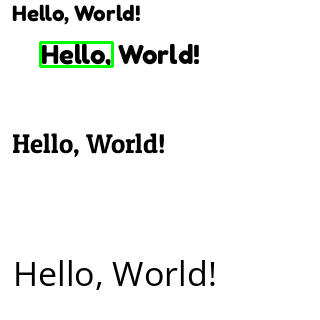

3


3


3


3


3


3


3


3


In [ ]:

from transformers import TrOCRProcessor
trocr_processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")


east_model_path = "frozen_east_text_detection.pb"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image_path = "/content/test_image_with_multiple_fonts4.jpg"


crops = detect_text(image_path, east_model_path)

trained_model = torch.load('/content/drive/MyDrive/tcr_ocr_font_classification_model.pth', map_location ='cpu')
trained_model.to(device)
trained_model.eval()

for image in crops:
  cv2_imshow(image)
  inputs = trocr_processor(images=image, return_tensors="pt")
  inputs['pixel_values'] = inputs['pixel_values'].to(device)
  outputs = trained_model(inputs['pixel_values'])
  print(outputs.argmax().item())



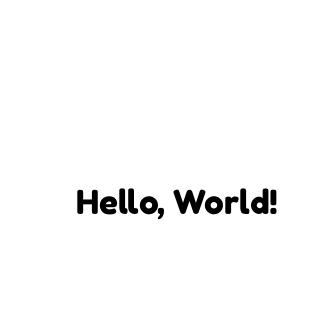

tensor([[-0.5313, -1.6624, -0.7177,  6.2078, -2.0525,  1.1578, -0.5623, -1.7487,
         -0.9287, -0.1421]], grad_fn=<AddmmBackward0>)


In [ ]:
image_path = "/content/image_0.jpg"
image = cv2.imread(image_path)
cv2_imshow(image)
inputs = trocr_processor(images=image, return_tensors="pt")
inputs['pixel_values'] = inputs['pixel_values'].to(device)
outputs = trained_model(inputs['pixel_values'])
print(outputs)

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


TypeError: Expected state_dict to be dict-like, got <class '__main__.VisionEncoderFontClassifier'>.